# 实现GPT2-small模型
在本篇笔记我们将会实现GPT2-small模型，并不包含训练过程.

## 1. 实现LayerNorm

In [43]:
import tiktoken
import torch

In [44]:
class LayerNorm(torch.nn.Module):
    def __init__(self, d_emb: int):
        """ 
        Args:
            d_emb (int): 词嵌入的维度大小
        """
        super().__init__()
        self.delta = 1e-5
        self.scale = torch.nn.Parameter(torch.ones(d_emb))
        self.shift = torch.nn.Parameter(torch.zeros(d_emb))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        mean = X.mean(dim=-1, keepdim=True)  # 默认X张量的最后一个维度为词嵌入的维度
        var = X.var(dim=-1, keepdim=True, unbiased=False)  # 使用有偏方差
        X_normed = (X - mean) / torch.sqrt(var + self.delta)
        return X_normed * self.scale + self.shift

In [45]:
# 测试一下LayerNorm：
torch.manual_seed(123)

X = torch.randn(2, 5)
print(f"X is: \n{X}")

layer_norm = LayerNorm(5)
X_normed = layer_norm(X)

# 验证X_normed的均值和标准差是否分别接近0和1：
mean = X_normed.mean(dim=-1, keepdim=True)
var = X_normed.var(dim=-1, keepdim=True, unbiased=False)

torch.set_printoptions(sci_mode=False)
print(f"mean is: \n{mean}")
print(f"var is: \n{var}")

X is: 
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])
mean is: 
tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
var is: 
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## 2. 实现残差连接

In [46]:
# class Residual(torch.nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, X: torch.Tensor, R: torch.Tensor) -> torch.Tensor:
#         """ 
#         Args:
#             X: 主路径的输入
#             R: 残差路径的输入，其形状必须和X的相同
#         """
#         assert X.shape == R.shape, "主路径和残差路径的输入形状必须相同"
#         return X + R

# class Residual(torch.nn.Identity):
    # pass

In [47]:
# 创建一个5层、每层包含一个3*3的权重矩阵的深度网络
from typing import List

class DeepNet(torch.nn.Module):
    def __init__(self, layer_sizes: List[int], with_residuals: bool):
        super().__init__()
        self.with_residuals = with_residuals
        
        self.layers = self._init_layers(layer_sizes)

    def _init_layers(self, layer_sizes: List[int]):
        layers = []
        for i in range(len(layer_sizes) - 1):
            d_in, d_out = layer_sizes[i], layer_sizes[i+1]
            linear = torch.nn.Linear(d_in, d_out)
            relu = torch.nn.ReLU()
            layer = torch.nn.Sequential(linear, relu)
            layers.append(layer)
        return torch.nn.Sequential(*layers)
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            Y = layer(X)
            if self.with_residuals and Y.shape == X.shape:
                Y = Y + X
            X = Y
        return X


def print_gradients(model: torch.nn.Module, X: torch.Tensor):
    # 前向传播
    output = model(X)
    target = torch.tensor([[0.]])

    # 根据输出和标签差距来计算损失
    loss = torch.nn.MSELoss()
    loss = loss(output, target)
    
    # 反向传播计算梯度
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # 打印权重的平均绝对梯度
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [48]:

# 先观察不使用残差连接的深度网络的梯度传播情况
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_residuals = DeepNet(layer_sizes, with_residuals=False)
print_gradients(model_without_residuals, sample_input)

layers.0.0.weight has gradient mean of 0.0006875668186694384
layers.1.0.weight has gradient mean of 0.0019083978841081262
layers.2.0.weight has gradient mean of 0.0038205476012080908
layers.3.0.weight has gradient mean of 0.003861031262204051
layers.4.0.weight has gradient mean of 0.024814950302243233


可以看到，浅层（接近第1层）的梯度变得越来越少。

In [49]:
# 然后观察一下使用了残差连接的情况
torch.manual_seed(123)

model_with_residuals = DeepNet(layer_sizes, with_residuals=True)
print_gradients(model_with_residuals, sample_input)

layers.0.0.weight has gradient mean of 0.5557742714881897
layers.1.0.weight has gradient mean of 0.09135335683822632
layers.2.0.weight has gradient mean of 0.7913904190063477
layers.3.0.weight has gradient mean of 0.21711303293704987
layers.4.0.weight has gradient mean of 3.140749216079712


- GELU ([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415))用多种实现；其精确版本定义为$GELU(x)=x\cdot \phi(x)$，其中$\phi(x)$是标准高斯分布的累积分布函数。
- 在实际应用中，常常采用计算成本较低的近似形式：$\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)$（原始的GPT-2模型也是使用这个近似形式进行训练的）。


## 3. 实现GELU激活函数

In [50]:
class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        Y = 0.5 * X * (1 + torch.tanh((2 / torch.pi) ** 0.5 * (X + 0.044715 * torch.pow(X, 3))))
        return Y

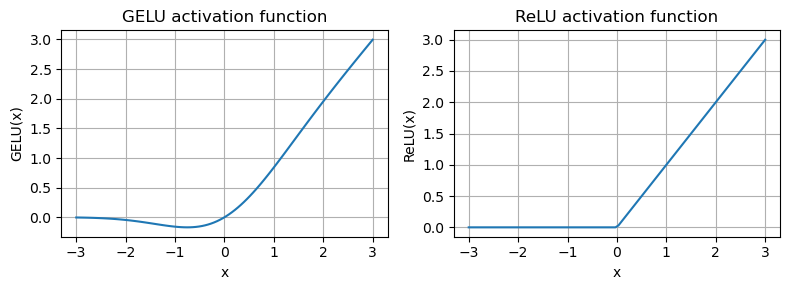

In [51]:
# 画出GELU激活函数的函数图像：
import matplotlib.pyplot as plt

gelu, relu = GELU(), torch.nn.ReLU()

# 样本数据
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

## 4. 实现FeedForward模块
这里将会实现如下结构的FeedForward子网络：
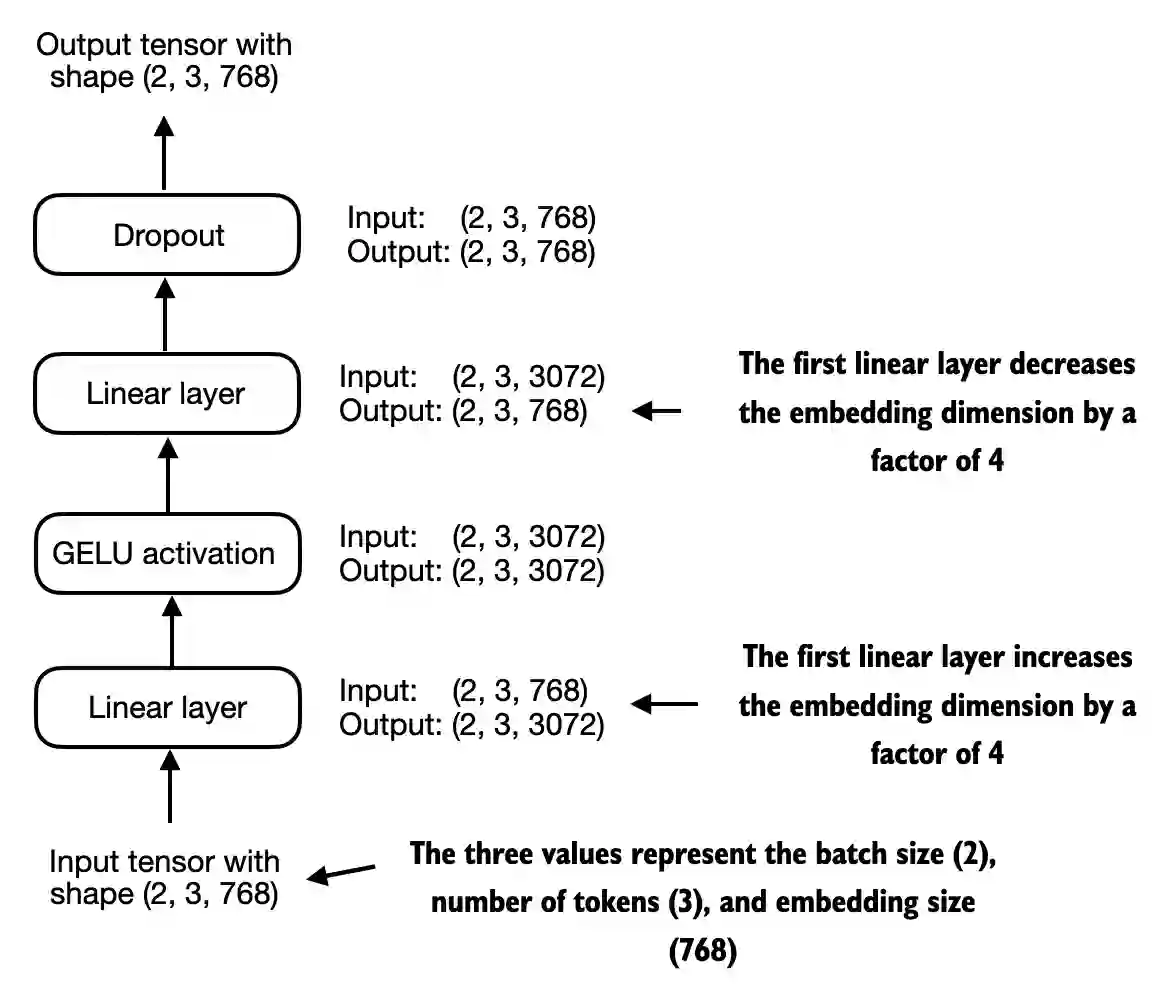

In [52]:
class FeedForward(torch.nn.Module):
    def __init__(self, emb_dim: int, dropout_rate: float):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(emb_dim, 4 * emb_dim),
            GELU(),
            torch.nn.Linear(4 * emb_dim, emb_dim),
            torch.nn.Dropout(dropout_rate)
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        Y = self.layers(X)
        return Y

In [53]:
ffn = FeedForward(emb_dim=768, dropout_rate=0.1)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)
assert out.shape == (2, 3, 768)

torch.Size([2, 3, 768])


## 5. 封装`transformer decoder-only`模块
我们在这里将会实现如下架构的`transormer decoder-only`模块：
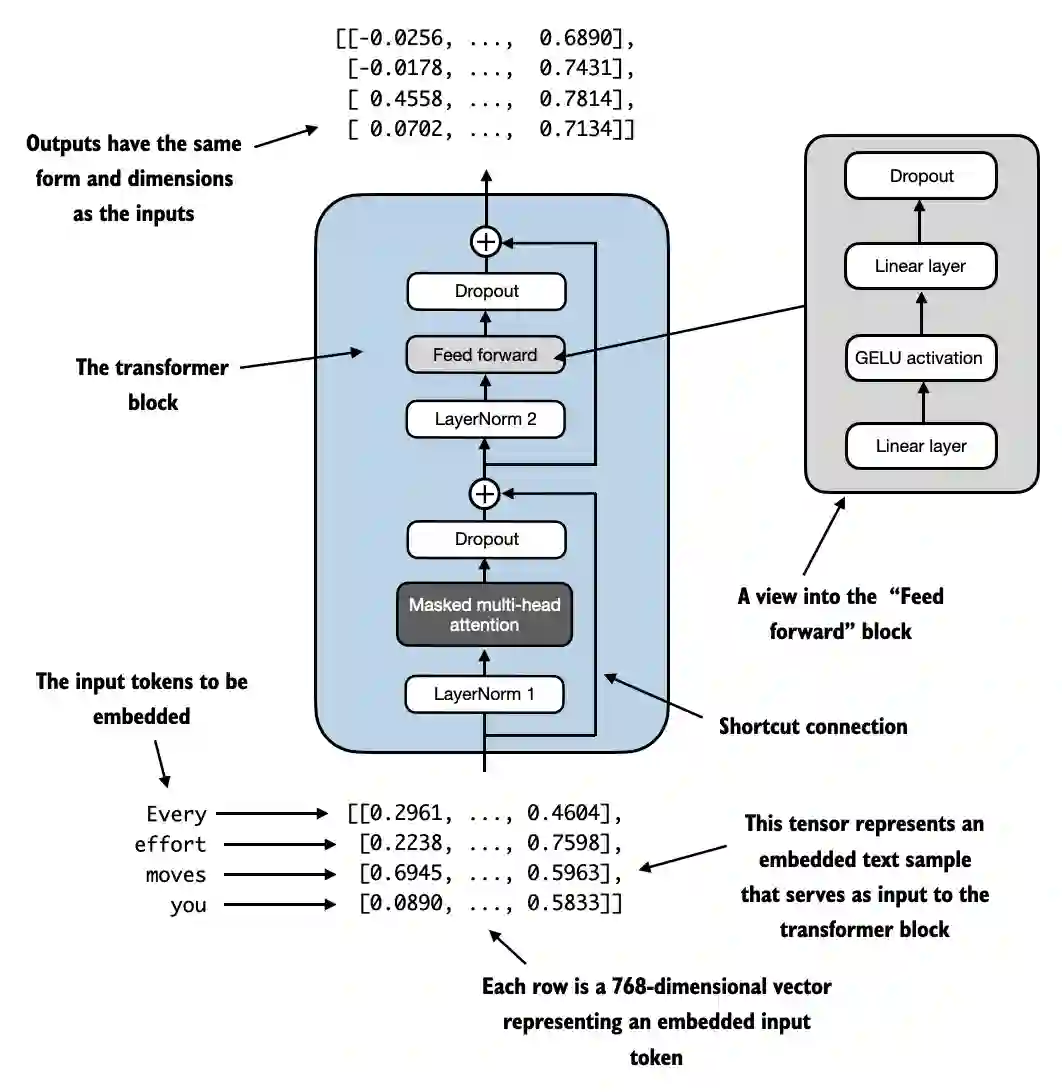

In [54]:
# 复用上一章实现的MultiHeadAttention:
from typing import Tuple

class MultiHeadAttention(torch.nn.Module):
    def __init__(
            self,
            d_in: int,
            d_out: int,
            max_num_tokens: int,
            num_heads: int,
            dropout_rate: float,
            with_bias: bool = False,
            with_mask: bool = False,
    ):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.max_num_tokens = max_num_tokens
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate
        self.with_bias = with_bias
        self.with_mask = with_mask

        if d_out % num_heads != 0:
            raise ValueError(f"d_out必须可以被num_heads整除")
        self.d_head = d_out // num_heads

        self.wq = None
        self.wk = None
        self.wv = None
        # self.mask = None
        self.dropout = None
        self.out_proj = None
        self._init_parameters()

    def _init_parameters(self):
        d_in, d_out, with_bias = self.d_in, self.d_out, self.with_bias
        self.wq = torch.nn.Linear(in_features=d_in, out_features=d_out, bias=with_bias)
        self.wk = torch.nn.Linear(in_features=d_in, out_features=d_out, bias=with_bias)
        self.wv = torch.nn.Linear(in_features=d_in, out_features=d_out, bias=with_bias)

        block_size = self.max_num_tokens
        if self.with_mask:
            mask = torch.triu(torch.ones(block_size, block_size), diagonal=1).bool()
            self.register_buffer(name="mask", tensor=mask)  # 保存模型时，也会同时保存掩码

        self.dropout = torch.nn.Dropout(p=self.dropout_rate)

        self.out_proj = torch.nn.Linear(d_out, d_out)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        batch_size, num_tokens, d_in = X.shape  # 这里需要获取实际输入数据集的上下文长度
        assert num_tokens <= self.max_num_tokens, f"输入序列长度 {num_tokens} 超过最大允许长度 {self.max_num_tokens}"
        assert d_in == self.d_in, "输入维度不正确"

        Q, K, V = self._compute_qkv(X)
        Q, K, V = self._reshape_qkv(Q, K, V, num_tokens)
        Q, K, V = self._transpose_qkv(Q, K, V)

        attention_scores = self._compute_attention_scores(Q, K)
        if self.with_mask:
            attention_scores = self._mask_attention_scores(attention_scores, num_tokens)

        attention_weights = self._compute_attention_weights(attention_scores)
        attention_weights = self.dropout(attention_weights)

        contexts = self._compute_contexts(attention_weights, V)
        contexts = self._transpose_contexts(contexts)
        contexts = self._reshape_contexts(contexts, num_tokens)
        
        Y = self.out_proj(contexts)
        return Y


    def _compute_qkv(self, X: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """ 
        X.shape:        (batch_size, num_tokens, d_in)
        Q, K, V.shape:  (batch_size, num_tokens, d_out)
        """
        Q, K, V = self.wq(X), self.wk(X), self.wv(X)
        return Q, K, V
    
    def _reshape_qkv(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, num_tokens: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """ 
        这里的num_tokens与self.num_tokens是不相同的，
        这里的num_tokens指的是输入数据的token数量，
        而self.num_tokens是初始化时设定的最大token数。
        """
        batch_size = Q.shape[0]
        """
        Q, K, V.shape:  (batch_size, num_tokens, d_out) -> (batch_size, num_tokens, num_heads, d_head)
        """
        Q = Q.reshape(batch_size, num_tokens, self.num_heads, self.d_head)
        K = K.reshape(batch_size, num_tokens, self.num_heads, self.d_head)
        V = V.reshape(batch_size, num_tokens, self.num_heads, self.d_head)
        return Q, K, V

    def _transpose_qkv(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """ 
        Q, K, V.shape:  (batch_size, num_tokens, num_heads, d_head) -> (batch_size, num_heads, num_tokens, d_head)
        """
        Q = Q.transpose(1, 2).contiguous()
        K = K.transpose(1, 2).contiguous()
        V = V.transpose(1, 2).contiguous()
        return Q, K, V
    
    def _compute_attention_scores(self, Q: torch.Tensor, K: torch.Tensor) -> torch.Tensor:
        """  
        attention_scores.shape: (batch_size, num_heads, num_tokens, num_tokens)
        """
        attention_scores = Q @ K.transpose(2, 3)
        return attention_scores
    
    def _mask_attention_scores(self, attention_scores: torch.Tensor, num_tokens: int) -> torch.Tensor:
        mask = self.mask[:num_tokens, :num_tokens]
        mask = mask.reshape(1, 1, num_tokens, num_tokens)  # 实际输入数据的token数量未必就是初始化时的token数
        attention_scores.masked_fill_(mask, -torch.inf)
        return attention_scores

    def _compute_attention_weights(self, attention_scores: torch.Tensor) -> torch.Tensor:
        """  
        attention_weights.shape: (batch_size, num_heads, num_tokens, num_tokens)
        """
        attention_weights = torch.softmax(attention_scores / self.d_head ** 0.5, dim=-1)
        return attention_weights
    
    def _compute_contexts(self, attention_weights: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
        """  
        contexts.shape: (batch_size, num_heads, num_tokens, d_head)
        """
        contexts = attention_weights @ V
        return contexts
    
    def _transpose_contexts(self, contexts: torch.Tensor) -> torch.Tensor:
        """
        contexts.shape: (batch_size, num_heads, num_tokens, d_head) -> (batch_size, num_tokens, num_heads, d_head)
        """
        contexts = contexts.transpose(1, 2).contiguous()
        return contexts
    
    def _reshape_contexts(self, contexts: torch.Tensor, num_tokens: int) -> torch.Tensor:
        """
        contexts.shape: (batch_size, num_tokens, num_heads, d_head) -> (batch_size, num_tokens, d_out)
        """
        batch_size = contexts.shape[0]
        contexts = contexts.reshape(batch_size, num_tokens, self.d_out)
        return contexts


In [55]:
# 实现我们的transformer decoder-only模块
class TransformerDecoderOnly(torch.nn.Module):
    def __init__(
        self,
        d_in: int,
        d_out: int,
        max_num_tokens: int,
        num_heads: int,
        dropout_rate: float,
        with_bias: bool = False,
        with_mask: bool = False
    ):
        # 这里的d_in和d_out都是相同的
        assert d_in == d_out, "d_in and d_out must be equal in decoder-only."
        super().__init__()
        # Dropout是公用的：
        self.drop = torch.nn.Dropout(dropout_rate)
        # LN + MHA + Dropout：
        self.norm1 = torch.nn.LayerNorm(d_in)
        self.mha = MultiHeadAttention(
            d_in=d_in,
            d_out=d_out,
            max_num_tokens=max_num_tokens,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            with_bias=with_bias,
            with_mask=with_mask
        )
        # LN + FFN + Dropout：
        self.norm2 = torch.nn.LayerNorm(d_out)
        self.ffn = FeedForward(emb_dim=d_out, dropout_rate=dropout_rate)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        shortcut = X
        X = self.norm1(X)
        X = self.mha(X)
        X = self.drop(X)
        X += shortcut

        shortcut = X
        X = self.norm2(X)
        X = self.ffn(X)
        X = self.drop(X)
        X += shortcut
        return X

In [56]:
""" 
GPT config is: 
vocab_size: 50257
ctx_len: 1024
emb_dim: 768
n_heads: 12
n_layers: 12
drop_rate: 0.1
qkv_bias: False
Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
"""
torch.manual_seed(123)

X = torch.rand(2, 4, 768)
tdo = TransformerDecoderOnly(
    d_in=768,
    d_out=768,
    max_num_tokens=1024,
    num_heads=12,
    dropout_rate=0.1,
    with_bias=False,
    with_mask=True
)
Y = tdo(X)
print(f"Input shape: {X.shape}")
print(f"Output shape: {Y.shape}")
# 输入和输出的形状应该是一样的：
assert X.shape == Y.shape

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


## 6. 实现GPT模型
我们要实现的GPT架构如下：
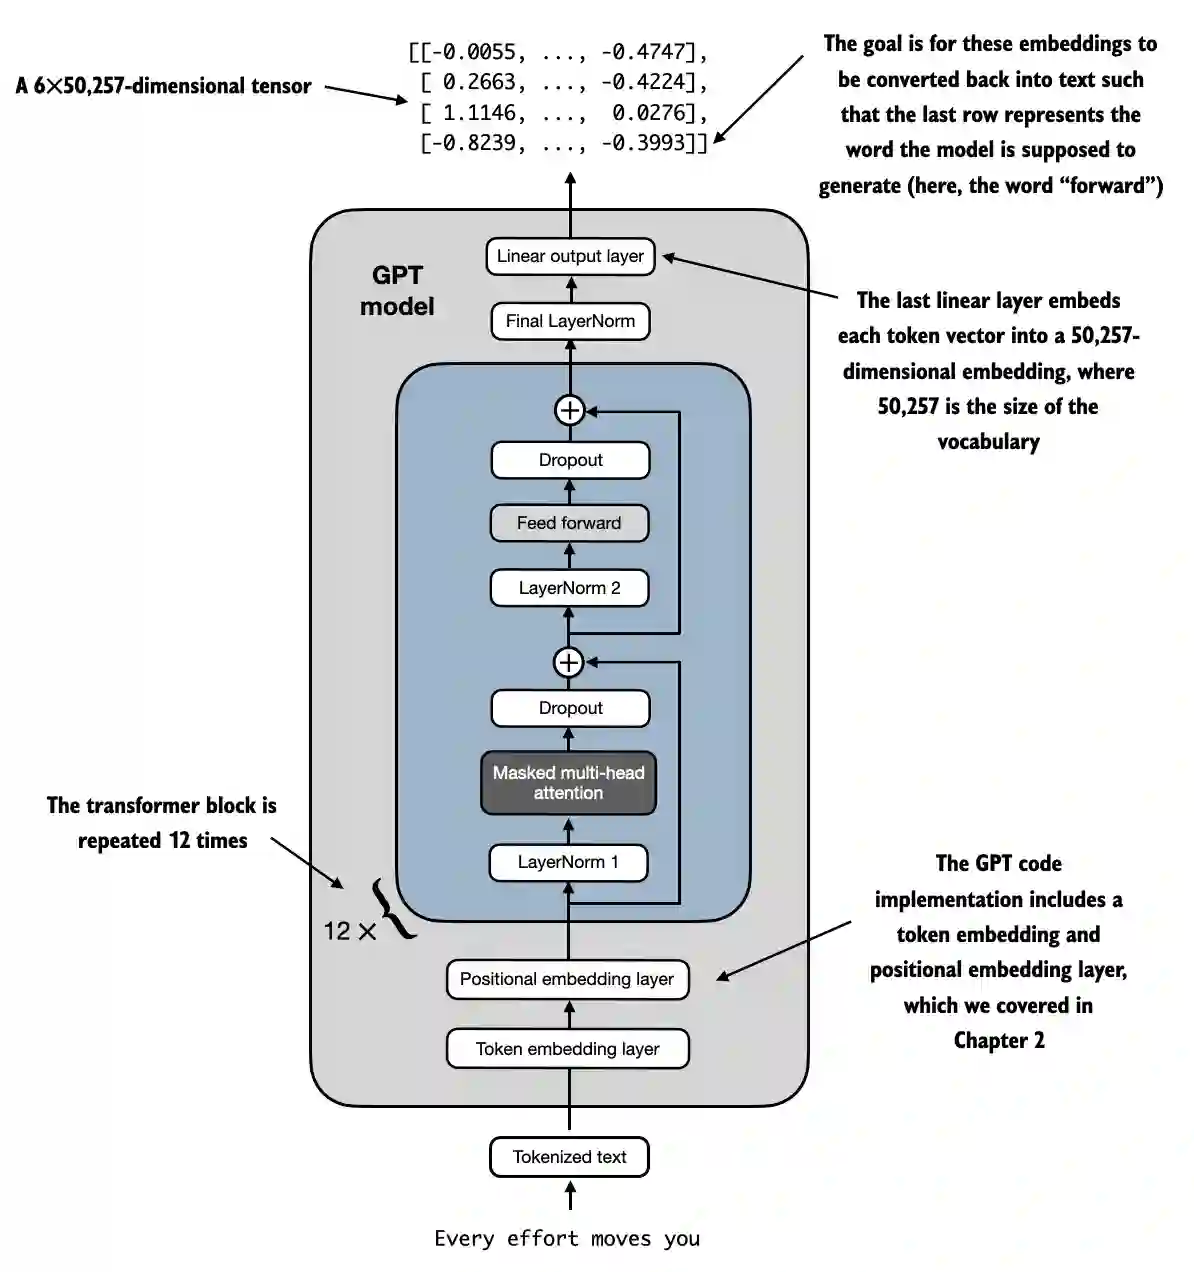

In [57]:
"""  
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["ctx_len"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
"""

class GPT2Small(torch.nn.Module):
    def __init__(
        self,
        vocab_size: int,
        ctx_len: int,
        emb_dim: int,
        n_heads: int,
        n_layers: int,
        dropout_rate: float,
        with_bias: bool = False,
        with_mask: bool = True
    ):
        super().__init__()

        self.tok_emb = torch.nn.Embedding(vocab_size, emb_dim)
        self.pos_emb = torch.nn.Embedding(ctx_len, emb_dim)
        self.decoder = torch.nn.Sequential(
            *[
                TransformerDecoderOnly(
                    d_in=emb_dim,
                    d_out=emb_dim,
                    max_num_tokens=ctx_len,
                    num_heads=n_heads,
                    dropout_rate=dropout_rate,
                    with_bias=with_bias,
                    with_mask=with_mask
                ) for _ in range(n_layers)
            ]
        )
        # self.norm = torch.nn.LayerNorm(emb_dim)
        self.norm = LayerNorm(emb_dim)
        self.out = torch.nn.Linear(emb_dim, vocab_size, bias=with_bias)

    def forward(self, input_indices: torch.Tensor) -> torch.Tensor:
        # X是输入的token索引，形状为[batch_size, seq_len]
        batch_size, seq_len = input_indices.shape
        token_embeds = self.tok_emb(input_indices)
        position_embeds = self.pos_emb(torch.arange(seq_len, device=input_indices.device))
        X = token_embeds + position_embeds
        X = self.decoder(X)
        X = self.norm(X)
        Y = self.out(X)
        return Y


In [58]:
""" 
GPT config is: 
vocab_size: 50257
ctx_len: 1024
emb_dim: 768
n_heads: 12
n_layers: 12
drop_rate: 0.1
qkv_bias: False
Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])
"""
model = GPT2Small(
    vocab_size=50257,
    ctx_len=1024,
    emb_dim=768,
    n_heads=12,
    n_layers=12,
    dropout_rate=0.1,
    with_bias=False,
    with_mask=True
)

tokenizer = tiktoken.get_encoding("gpt2")
batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.0359,  0.1277, -0.3412,  ..., -0.3470,  0.8628,  0.8957],
         [-0.1713,  1.0491, -0.8684,  ..., -0.2338, -0.1304, -0.0807],
         [-0.3930,  0.9175, -0.5629,  ..., -0.3837, -0.4444, -0.2355],
         [ 0.7052,  0.8655,  0.0633,  ..., -0.0181, -1.0950, -0.4965]],

        [[-0.0041, -0.0847, -0.1331,  ..., -0.8487,  1.0287,  0.7838],
         [ 0.0525,  0.6175, -0.5145,  ..., -0.0415,  0.2780, -0.5961],
         [ 0.1981, -0.6855, -0.8513,  ..., -0.0083,  0.3735, -0.6017],
         [ 1.0542, -0.3154,  0.0600,  ...,  0.5852,  0.4260,  0.0338]]],
       grad_fn=<UnsafeViewBackward0>)


In [59]:
# 计算一下模型的参数量：
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")
# 163,059,793
# assert total_params == 163009536

Total number of parameters: 163,009,536


## 7. 使用GPT模型生成文本

In [60]:
def generate_text_simple(model: torch.nn.Module, indices: torch.Tensor, max_new_tokens: int, context_size: int):
    """ 
    Args:
        model: GPT2 Small模型
        indices: 初始的上下文索引数组，形状为(B, T)
        max_new_tokens: 生成的最大新token数量
        context_size: 当前的上下文长度
    """
    for _ in range(max_new_tokens):
        # 如果当前上下文超过了支持的长度，就对当前上下文进行截断
        # 例如，如果LLM只支持5个token，而上下文长度为10，
        # 那么只有最后5个token会被用作上下文
        idx_cond = indices[:, -context_size:]
        
        # 获取预测结果
        with torch.no_grad():
            logits = model(idx_cond)
        
        # 只关注最后一个时间步
        # (batch, n_token, vocab_size)变为(batch, vocab_size)
        logits = logits[:, -1, :]  

        # 通过softmax函数获得对应的概率
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # 获取概率值最高的单词索引
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # 将采样到的索引添加到当前运行的上下文索引序列中
        indices = torch.cat((indices, idx_next), dim=1)  # (batch, n_tokens+1)

    return indices

In [61]:
# 测试一下：
start_context = "Hello, I am"

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

out = generate_text_simple(
    model=model,
    indices=encoded_tensor,
    max_new_tokens=1,  # 生成下一个token
    context_size=1024
)

print("Output:", out)
print("Output length:", len(out[0]))

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)  # 由于分词算法使用的是基于subword粒度的BPE算法，所以解码后得到的序列长度有可能少于解码前的tokens序列长度

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
Output: tensor([[15496,    11,   314,   716, 15086]])
Output length: 5
Hello, I amSil


In [63]:
# 逐层打印模型的参数量：
decoder_params_num = 0
for name, params in model.named_parameters():
    if name.startswith("decoder"):
        decoder_params_num += params.numel()
    else:
        print(f"{name}: {params.numel()}")
print(f"decoder: {decoder_params_num}")

tok_emb.weight: 38597376
pos_emb.weight: 786432
norm.scale: 768
norm.shift: 768
out.weight: 38597376
decoder: 85026816
